In [14]:
from omegaconf import OmegaConf
import torchvision

from settings import *
from data import *
from model_visual import *

import PIL
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image

In [15]:
args = OmegaConf.load(ROOT_DIR+'/configs/config.yaml')
device = torch.device("cpu")

In [16]:
# Load a prer-trained image model
image_model = ResNet50(args.image_model.hid_dim, args.opts.n_classes, args.image_model.dropout).to(device)
file = torch.load(TRAINED_MODELS_DIR + '/image_model/best_image_model.pt', map_location=device)
image_model.load_state_dict(file['model'])

<All keys matched successfully>

In [17]:
print(image_model.model_wo_fc)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [18]:
# Define an extractor to obtain GradCAM explanations
cam_extractor = GradCAM(image_model, image_model.model_wo_fc[7])

In [48]:
train_dataset = MIMIC_CXR(REPORT_PREPROCESS_DIR + '/train_output.jsonl', IMG_DIR_TRAIN, train_flag=True)
word_idx = train_dataset.word_idx
test_dataset = MIMIC_CXR(REPORT_PREPROCESS_DIR + '/test_output.jsonl', IMG_DIR_TEST, word_idx=word_idx)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, drop_last=False, collate_fn=collate_fn)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels      -> tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.])
Predictions -> tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       grad_fn=<RoundBackward>)


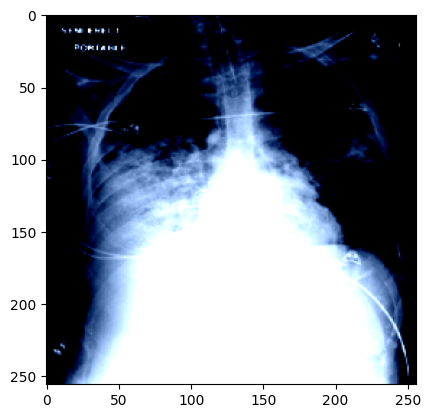

In [47]:
# Get predictions for one sample: as we can see, the model only misclassifies classes 1 and 2
image, _, labels = test_dataset[6]
_, logits = image_model(image.unsqueeze(0).to(device))
probs = torch.sigmoid(logits.squeeze())
preds = torch.round(probs)
print(f'Labels      -> {labels}')
print(f'Predictions -> {preds}')
plt.imshow(image.permute(1,2,0))

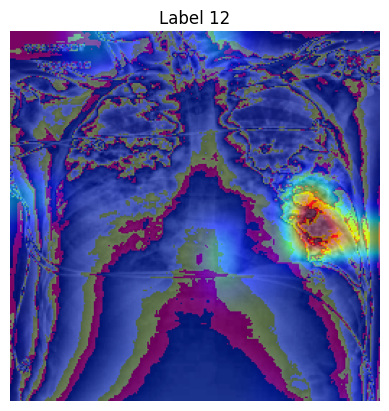

In [37]:
# For each correct prediction that indicates the presence of a disease (label 1), we compute explanations
for i, label in enumerate(labels):
    label = label.item()
    pred = preds[i].item()
    if label == pred and label == 1.:
        _, logits = image_model(image.unsqueeze(0).to(device))
        cam = cam_extractor(i, logits)[0]
        resize = torchvision.transforms.Resize((image.shape[1], image.shape[2]), interpolation=PIL.Image.BICUBIC)
        mask = resize(cam).squeeze(0)
        #plt.imshow(mask)
        
        result = overlay_mask(to_pil_image(image), to_pil_image(cam.squeeze(0), mode='F'), alpha=0.5)
        plt.imshow(result); plt.axis('off'); plt.title(f'Label {i}'); plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


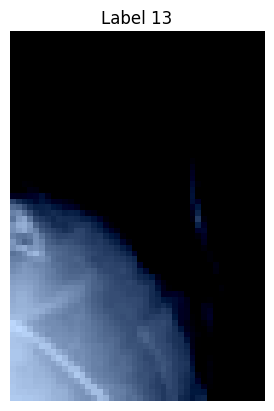

In [40]:
# We extract the most relevant patch for the lastly computed heatmap (label 12)
# There is actually an error in the plot, because the index "i" corresponds to
# the last class, because of the loop in the previos cell
patch = image.numpy().transpose(1, 2, 0)
topx, topy = find_most_salient_patch(mask)
patch = patch[y:y+64, x:x+64]
patch = patch / np.max(patch)

plt.imshow(patch); plt.axis('off'); plt.title(f'Label {i}'); plt.show()

In [30]:
# By using just the extracted patch, the model still correctly predicts class 12
features, logits = image_model(torch.tensor(patch.transpose(2,0,1)).unsqueeze(0).to(device))
probs = torch.sigmoid(logits.squeeze())
preds = torch.round(probs)
print(f'Labels      -> {labels}')
print(f'Predictions -> {preds}')
print(f'Features -> {features.shape}')

Labels      -> tensor([0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.])
Predictions -> tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       grad_fn=<RoundBackward>)
Features -> torch.Size([1, 256])
